In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from netgraph import Graph, ArcDiagram
import networkx as nx
from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# download relevant nltk datasets
download("wordnet")
download("omw-1.4")
download("punkt")
download("averaged_perceptron_tagger")
download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# load pages
with open("cains_jawbone.txt", "r", encoding="utf-8") as f:
    pages = f.read().split("\n\n")

In [5]:
# preprocess and tokenize pages
lemmatizer = WordNetLemmatizer()

def get_pos(tag: str) -> str | None:
    match tag[0]:
        case "J":
            return wordnet.ADJ
        case "R":
            return wordnet.ADV
        case "N":
            return wordnet.NOUN
        case "V":
            return wordnet.VERB
        case _:
            return None

def preprocess(text: str) -> str:
    tokens = [token for token in word_tokenize(text.lower())]
    tagged = [(word, get_pos(tag)) for word, tag in pos_tag(tokens)]
    lemmatized = [lemmatizer.lemmatize(word, pos=tag) for (word, tag) in tagged if tag is not None]
    return " ".join(lemmatized)

data = [preprocess(page) for page in pages]

In [6]:
# vectorize tokens to frequencies
vectorizer = TfidfVectorizer()
freqs = vectorizer.fit_transform(data)

In [7]:
# calculate cosine similarities between pages
weights = np.zeros((len(pages), len(pages)))
for (i, j) in np.ndindex(weights.shape):
    weights[i, j] = cosine_similarity(freqs[i], freqs[j]).flatten()[0]

In [8]:
# generate fully connected, weighted graph
G = nx.complete_graph(len(pages))
for (i, j) in G.edges:
    G.edges[i, j]["weight"] = weights[i, j]

minimum 0.019894622187133587
   mean 0.08425618893009772 +- 0.029549702772006203
maximum 0.3300537936923397


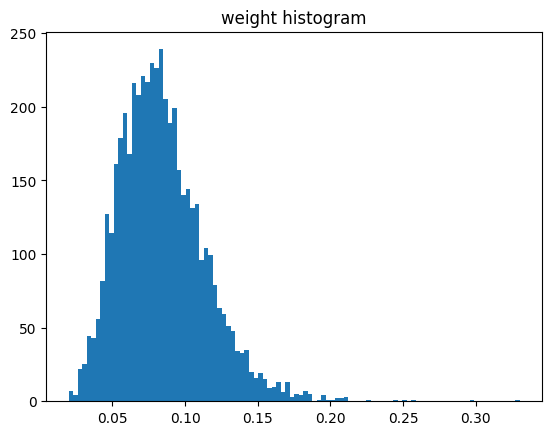

In [9]:
# weight statistics
stats = np.array([G.edges[edge]["weight"] for edge in G.edges])

print("minimum", stats.min())
print("   mean", stats.mean(), "+-", stats.std())
print("maximum", stats.max())

plt.hist(stats, bins=100)
plt.title("weight histogram")
plt.show()

In [10]:
# detect communities
communities = nx.community.louvain_communities(G, weight="weight", seed=0)

print(len(communities), "communities:")
for community in communities:
    print(*community)

3 communities:
1 2 3 67 71 73 10 76 78 15 79 81 82 20 21 22 86 84 25 91 93 30 99 37 41 43 46 48 57 61 62
0 4 6 8 9 11 13 17 18 19 24 26 31 32 35 36 38 40 44 45 47 49 50 54 56 59 60 63 68 69 70 77 85 87 90 92 94 96 98
64 65 66 5 7 72 74 75 12 14 80 16 83 23 88 89 27 28 29 95 97 34 33 39 42 51 52 53 55 58


In [17]:
# plot complete graph with similarity as opacity for edges and colors for communities (and/or grouping in layout)

In [11]:
comm_dict = {}
for i, community in enumerate(communities):
    for node in community:
        comm_dict[node] = i

colors = mpl.colormaps["tab10"].colors[:len(communities)]
node_color = {node: colors[i] for node, i in comm_dict.items()}

edge_dict = {(i, j) : G.edges[(i,j)]["weight"] / stats.max() for (i, j) in G.edges}

c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


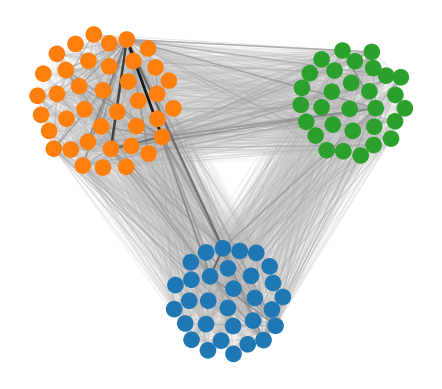

In [12]:
Graph(
    G,
    node_color=node_color,
    node_edge_width=0,
    edge_alpha=edge_dict,
    edge_width=edge_dict,
    node_layout="community",
    node_layout_kwargs=dict(node_to_community=comm_dict),
)

plt.show()

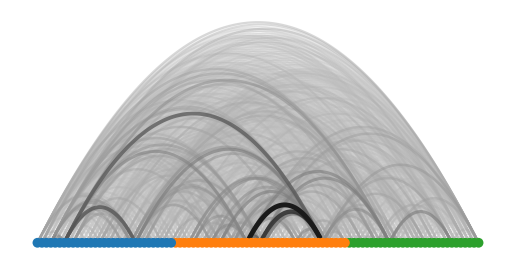

In [13]:
node_order = []
for community in communities:
    node_order += sorted(community)

ArcDiagram(
    G,
    node_order=node_order,
    node_size=1,
    node_color=node_color,
    node_edge_width=0,
    edge_alpha=edge_dict,
    edge_width=edge_dict,
)

plt.show()

In [18]:
# Graph Traversal Algorithm

# maximum spanning tree?
# depth first search?
# traveling salesman problem?
# start at which node?

In [33]:
# naiv way: start at root and go to highest similarity in each step
def max_path(graph, root):
    visited = [root]
    for i in range(len(graph)-1):
        weights = [(node, graph.edges[(visited[i], node)]["weight"]) for node in graph if node not in visited]
        new = max(weights, key=(lambda x: x[1]))
        visited.append(new[0])
    return visited

0, 88, 45, 87, 38, 33, 75, 27, 32, 90, 58, 85, 8, 24, 99, 76, 78, 21, 10, 71, 61, 2, 97, 1, 53, 63, 18, 31, 86, 79, 52, 25, 91, 95, 65, 39, 28, 34, 74, 35, 69, 49, 14, 46, 41, 12, 57, 48, 68, 98, 36, 55, 84, 81, 16, 42, 47, 13, 9, 17, 92, 40, 11, 73, 44, 77, 80, 23, 82, 67, 4, 7, 66, 54, 22, 5, 70, 19, 59, 94, 6, 26, 3, 20, 30, 89, 64, 51, 56, 96, 62, 43, 93, 15, 60, 72, 29, 37, 83, 50


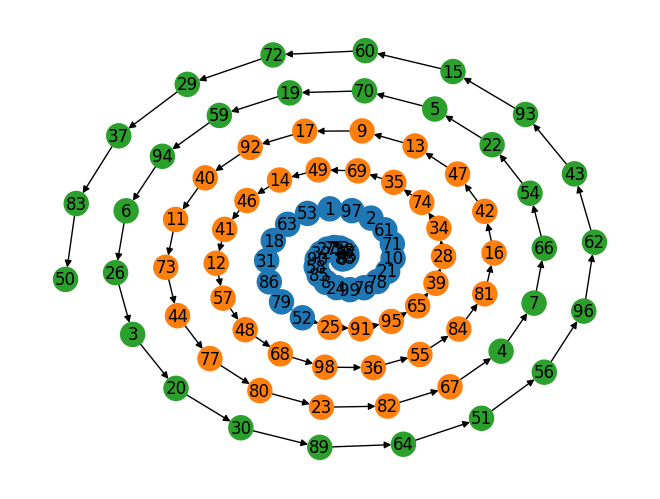

In [51]:
path = max_path(G, 0)
print(*path, sep=", ")
P = nx.path_graph(len(path), create_using=nx.DiGraph)
P = nx.relabel_nodes(P, {i: node for i, node in enumerate(path)})
pos = nx.spiral_layout(P)
nx.draw(P, pos, with_labels=True, node_color=list(node_color.values()))